In [3]:
import pandas as pd
import csv
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
path = 'D:/DATA FOR RESEARCH PROJECT/Clean data/pacemakerClean2.csv'
df = pd.read_csv(path, dtype=str)

In [5]:
# filter and clean data
df = df[df["FOI_TEXT"].notna()]
df = df[df["ADVERSE_EVENT_FLAG"].isin(['Y', 'N', 'True', 'False', True, False])]

In [6]:
# Clean the text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["FOI_TEXT_CLEAN"] = df["FOI_TEXT"].apply(clean_text)
df = df[df["FOI_TEXT_CLEAN"].str.strip() != ""]

In [7]:
# Map target to binary
df["ADVERSE_EVENT_FLAG"] = df["ADVERSE_EVENT_FLAG"].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0})

In [8]:
df.head()

,MDR_REPORT_KEY,DATE_RECEIVED_x,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_ADDRESS_1,MANUFACTURER_D_CITY,MANUFACTURER_D_STATE_CODE,MANUFACTURER_D_ZIP_CODE,MANUFACTURER_D_COUNTRY_CODE,...,SOURCE_TYPE,DATE_ADDED,DATE_CHANGED,REPORTER_COUNTRY_CODE,PMA_PMN_NUM,SUMMARY_REPORT,NOE_SUMMARIZED,SUPPL_DATES_FDA_RECEIVED,SUPPL_DATES_MFR_RECEIVED,FOI_TEXT_CLEAN
0,16081313,2023-01-01,ASSURITY MRI,IMPLANTABLE PACEMAKER PULSE GENERATOR,ABBOTT,15900 VALLEY VIEW COURT,SYLMAR,CA,91342,US,...,"01,05,07",2023-01-01,2024-01-29,UK,P140033,False,1,2023-02-06,2023-01-31,it was reported that the device was prophylact...
1,16081360,2023-01-01,CAPSUREFIX NOVUS LEAD MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,MEDTRONIC SINGAPORE OPERATIONS,49 CHANGI SOUTH AVENUE 2,SINGAPORE,NaN,48605,SN,...,"01,05,07",2023-01-01,2024-02-27,GM,P930039,False,1,2023-01-10,2023-01-09,it was reported that the right ventricular rv ...
2,16081369,2023-01-01,CAPSUREFIX NOVUS MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,MEDTRONIC SINGAPORE OPERATIONS,49 CHANGI SOUTH AVENUE 2,SINGAPORE,NaN,48605,SN,...,"01,05,07",2023-01-01,2024-02-27,SW,P930039,False,1,NaN,NaN,medtronic is submitting this report to comply ...
3,16081371,2023-01-01,ASSURITY MRI,IMPLANTABLE PACEMAKER PULSE GENERATOR,"ST. JUDE MEDICAL, INC.(CRM-SYLMAR)",15900 VALLEY VIEW COURT,SYLMAR,CA,91342,US,...,"01,05,06,07",2023-01-01,2023-01-04,UK,P140033,False,1,NaN,NaN,it was reported that the device was prophylact...
4,16081384,2023-01-01,ASSURITY MRI,IMPLANTABLE PACEMAKER PULSE GENERATOR,"ST. JUDE MEDICAL, INC.(CRM-SYLMAR)",15900 VALLEY VIEW COURT,SYLMAR,CA,91342,US,...,"01,05,06,07",2023-01-01,2023-02-23,UK,P140033,False,1,2023-02-22,2023-02-07,the reported event was the prophylactic explan...


In [9]:
# vectorizing text and splitting for train/test split
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df["FOI_TEXT_CLEAN"])
y = df["ADVERSE_EVENT_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# train classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.61      0.71     28805
           1       0.68      0.88      0.77     27636

    accuracy                           0.74     56441
   macro avg       0.76      0.74      0.74     56441
weighted avg       0.76      0.74      0.74     56441



In [11]:
# Top keywords for adverse events
import numpy as np
feature_names = vectorizer.get_feature_names_out()
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1][:100]

print("\nTop 100 keywords most associated with adverse events:\n")
for idx in sorted_idx:
    print(f"{feature_names[idx]:<20}  → importance: {importances[idx]:.4f}")


Top 100 keywords most associated with adverse events:

explanted             → importance: 0.0356
replaced              → importance: 0.0215
reflects              → importance: 0.0209
form                  → importance: 0.0148
fda                   → importance: 0.0139
received              → importance: 0.0138
information           → importance: 0.0136
notification          → importance: 0.0134
zoll                  → importance: 0.0127
infection             → importance: 0.0127
medical               → importance: 0.0118
patient               → importance: 0.0113
provided              → importance: 0.0110
lead                  → importance: 0.0106
corporation           → importance: 0.0101
use                   → importance: 0.0100
report                → importance: 0.0095
additional            → importance: 0.0094
reported              → importance: 0.0092
remains               → importance: 0.0084
implant               → importance: 0.0081
device                → importance: 0.007

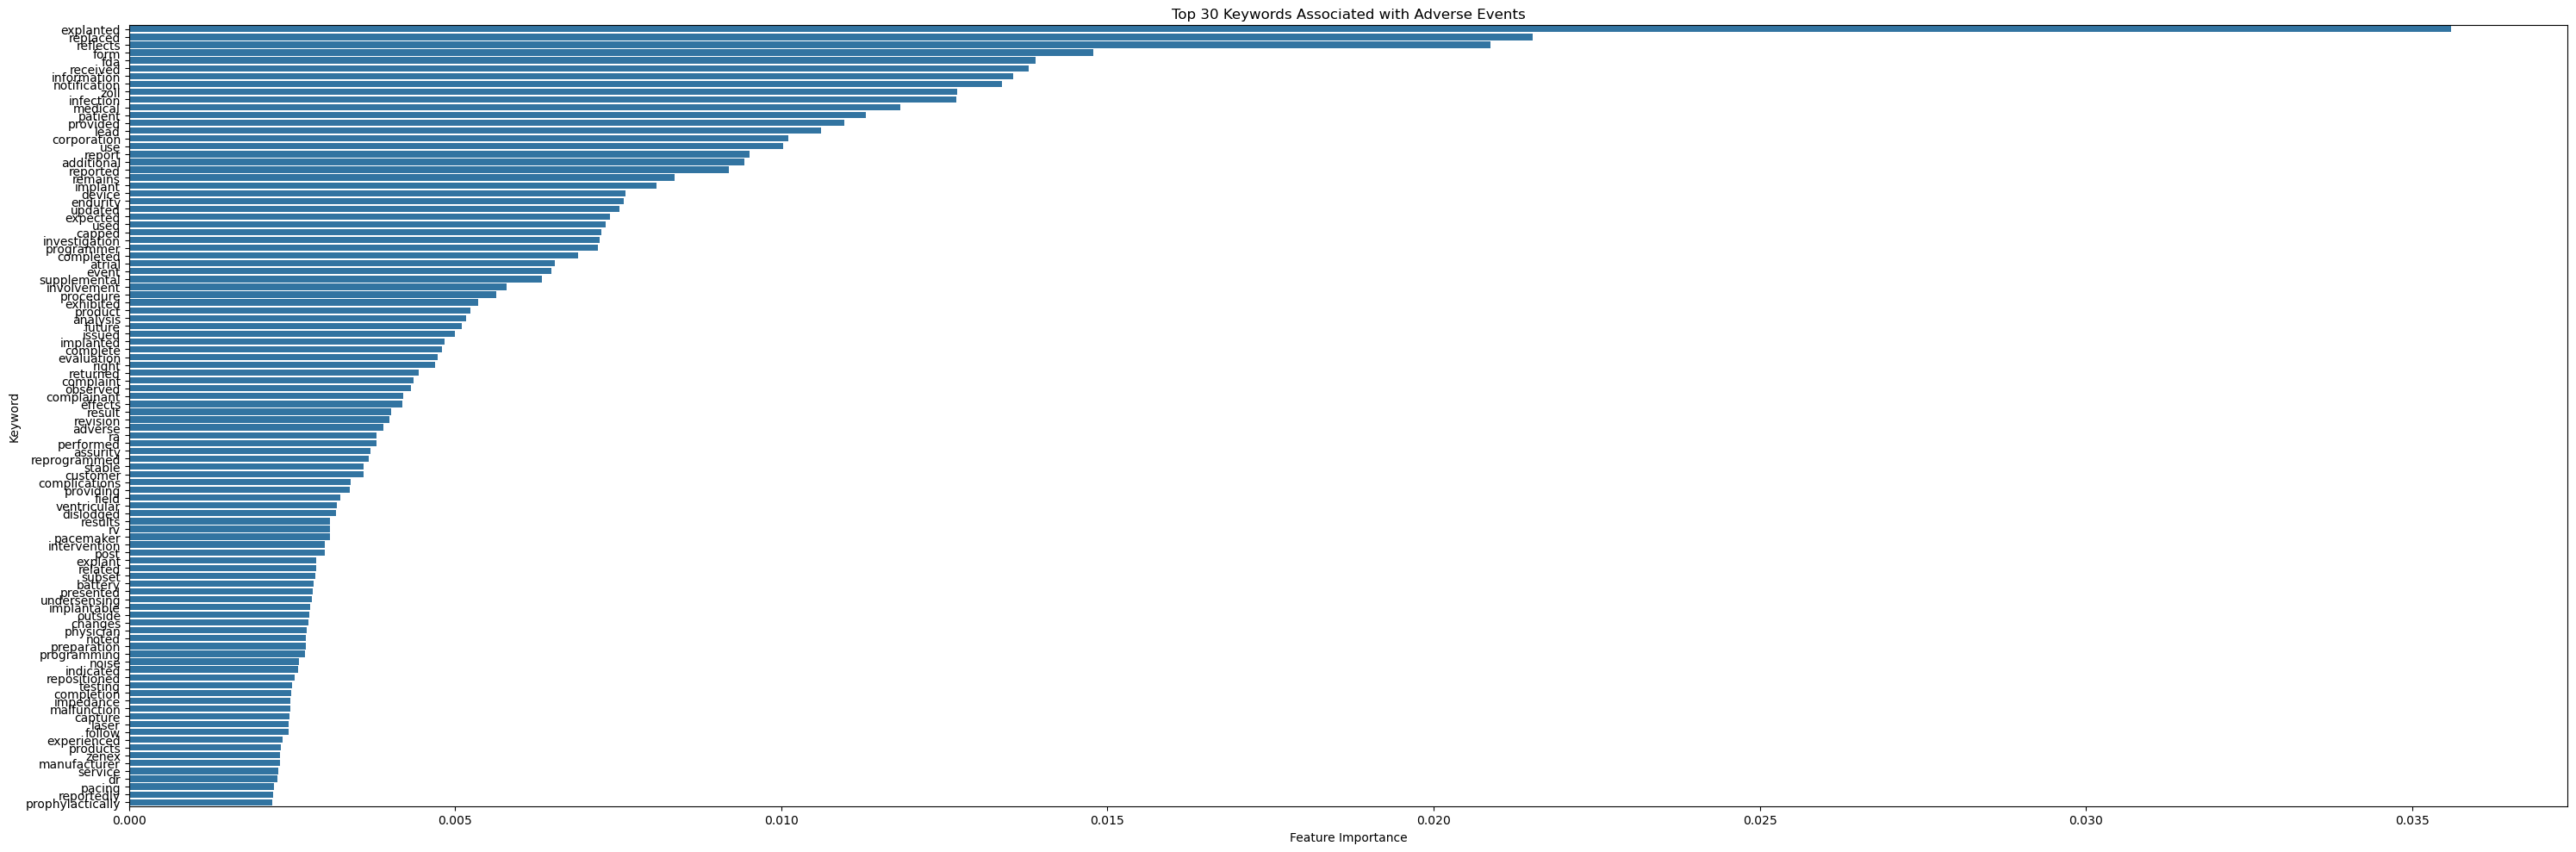

In [12]:
import seaborn as sns
plt.figure(figsize=(30, 10))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
plt.title("Top 30 Keywords Associated with Adverse Events")
plt.xlabel("Feature Importance")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

In [13]:
failure_keywords = [
    "death", "deceased", "died", "fail", "failure", "shock", "pain", "malfunction",
    "burn", "explode", "infection", "fracture", "dislodgement", "battery", "inappropriate shock"
]

# Flag rows
df["FAILURE_KEYWORD_FLAG"] = df["FOI_TEXT_CLEAN"].apply(
    lambda x: any(word in x for word in failure_keywords)
)

flagged_df = df[df["FAILURE_KEYWORD_FLAG"] == True][["FOI_TEXT", "ADVERSE_EVENT_FLAG"]]

# Export to CSV
flagged_df.to_csv("flagged_adverse_cases.csv", index=False)

print("\n✅ Exported flagged rows to 'flagged_adverse_cases.csv'")

# Step 6: Keyword search tool
def search_keyword(term):
    term = term.lower()
    return df[df["FOI_TEXT_CLEAN"].str.contains(term)][["FOI_TEXT", "ADVERSE_EVENT_FLAG"]]


✅ Exported flagged rows to 'flagged_adverse_cases.csv'


In [14]:
# Example usage
results = search_keyword("battery")
display(results.head())


,FOI_TEXT,ADVERSE_EVENT_FLAG
1,IT WAS REPORTED THAT THEÂ RIGHT VENTRICULAR (R...,0
4,THE REPORTED EVENT WAS THE PROPHYLACTIC EXPLAN...,1
17,RMS REPORTS DATA HAVE BEEN ANALYZED AND ESTIMA...,0
35,IT WAS REPORTED THAT THERE WERE CONCERNS OF PR...,1
38,IT WAS REPORTED THAT THE BATTERY OF THIS PACEM...,0


In [15]:
# this csv file contains 68,748 cases where the "adverse" words were identified
# There are cases where the event was actually adverse and classified as adverse
# but there are false positives and true negatives as well 
# for this, we will use a confusion matrix

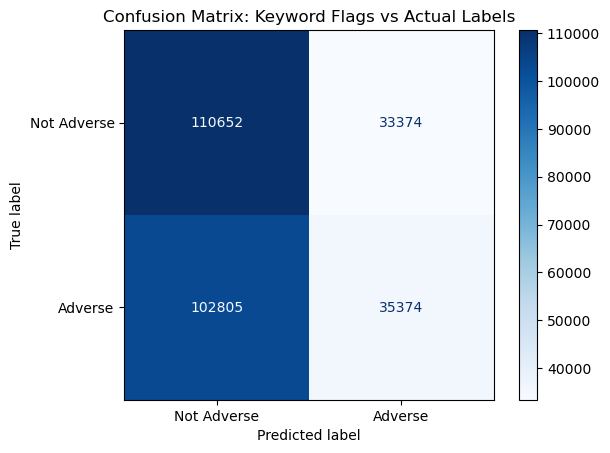

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Prepare inputs
y_true = df["ADVERSE_EVENT_FLAG"]  # actual label
y_pred = df["FAILURE_KEYWORD_FLAG"].astype(int)  # keyword-based prediction

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Adverse", "Adverse"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Keyword Flags vs Actual Labels")
plt.show()


In [18]:
# Simplified Parameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Smaller Data Sample 
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, 
    train_size=0.3,       # Use 30% of training data for quick tuning
    stratify=y_train, 
    random_state=42
)

# GridSearchCV Setup
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,                 # Reduced CV folds for further speed-up
    verbose=2,
    n_jobs=-1
)

# Perform quick GridSearchCV
grid_search.fit(X_train_sample, y_train_sample)

# Display best parameters
print("Best parameters:", grid_search.best_params_)

# Retrain the best model on the FULL training dataset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_optimized = best_model.predict(X_test)
print("\nOptimized Model Classification Report:\n")
print(classification_report(y_test, y_pred_optimized))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Optimized Model Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.61      0.71     28805
           1       0.68      0.88      0.77     27636

    accuracy                           0.74     56441
   macro avg       0.76      0.74      0.74     56441
weighted avg       0.76      0.74      0.74     56441



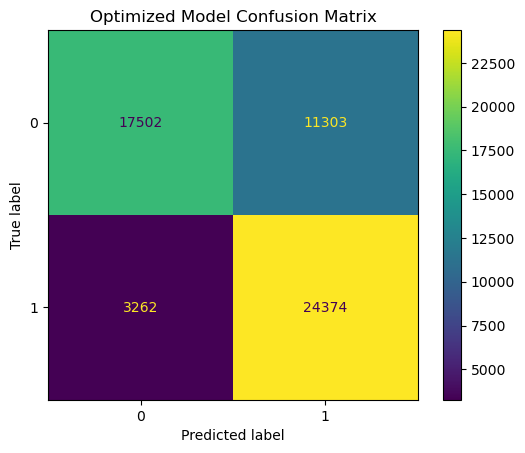

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Optimized Model Confusion Matrix")
plt.show()

In [25]:
# Further analysis of false positives and false negatives
false_pos_idx = (y_test == 0) & (y_pred_optimized == 1)
false_neg_idx = (y_test == 1) & (y_pred_optimized == 0)

false_positives = df.loc[y_test.index[false_pos_idx], ['FOI_TEXT', 'FOI_TEXT_CLEAN']]
false_negatives = df.loc[y_test.index[false_neg_idx], ['FOI_TEXT', 'FOI_TEXT_CLEAN']]

# Display a few examples
print("Sample False Positives (incorrectly classified as adverse events):\n", false_positives.head())
print("\nSample False Negatives (missed adverse events):\n", false_negatives.head())

Sample False Positives (incorrectly classified as adverse events):
                                                  FOI_TEXT  \
229780  IF INFORMATION IS PROVIDED IN THE FUTURE, A SU...   
164579  THE RESULTS OF THE INVESTIGATION ARE INCONCLUS...   
173177  CONCOMITANT MEDICAL PRODUCTS: BIS-BIS-40 CRDM ...   
253263  THE RESULTS OF THE INVESTIGATION ARE INCONCLUS...   
261367  THE RESULTS OF THE INVESTIGATION ARE INCONCLUS...   

                                           FOI_TEXT_CLEAN  
229780  if information is provided in the future a sup...  
164579  the results of the investigation are inconclus...  
173177  concomitant medical products bis bis crdm adap...  
253263  the results of the investigation are inconclus...  
261367  the results of the investigation are inconclus...  

Sample False Negatives (missed adverse events):
                                                  FOI_TEXT  \
2275    MEDTRONIC IS SUBMITTING THIS REPORT TO COMPLY ...   
207497  CONCOMITANT MEDICAL PRODU

In [27]:
# saving the false positives and false negatives as csv files
false_positives.to_csv("false_positives.csv", index=False)
false_negatives.to_csv("false_negatives.csv", index=False)

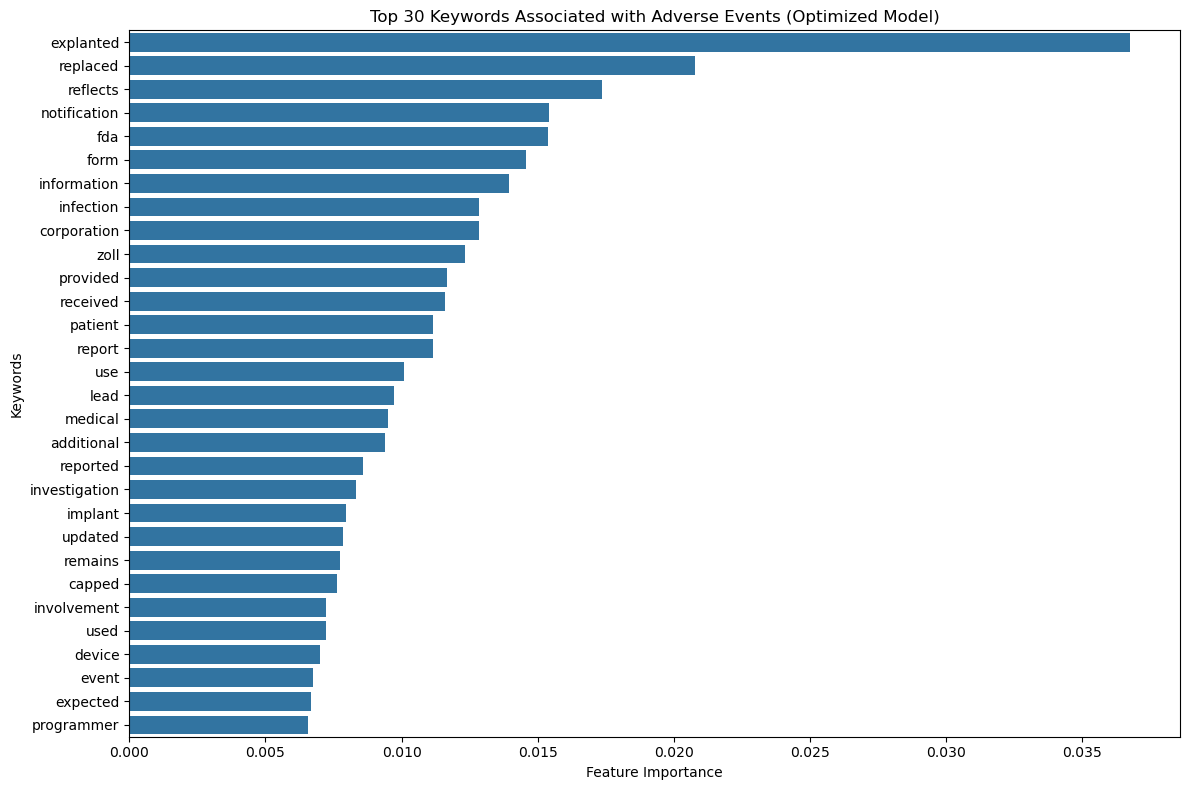

In [29]:
import seaborn as sns
import numpy as np

feature_names = vectorizer.get_feature_names_out()
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1][:30]  # Top 30 features

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Top 30 Keywords Associated with Adverse Events (Optimized Model)")
plt.xlabel("Feature Importance")
plt.ylabel("Keywords")
plt.tight_layout()
plt.show()